In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from keras import backend as K
from sklearn.model_selection import train_test_split
import h5py

#K.tensorflow_backend.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')

%matplotlib inline

np.random.seed(2)

In [3]:
target_size = (200, 200)
target_dims = (200, 200, 1)
num_classes = 5

# Função para verificar GPUs disponíveis
def get_available_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    return [gpu.name for gpu in gpus] if gpus else []

def load_local_dataset(dataset_path, target_size=(200, 200)):
    classes = sorted(os.listdir(dataset_path))  # Obtém a lista de classes (pastas A, E, I, O, U)
    images, labels = [], []
    
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega em escala de cinza
            if img is None:
                continue
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)  # Melhor interpolação para redução
            
            images.append(img)
            labels.append(label)
    
    images = np.array(images, dtype=np.uint8)  # Armazena como uint8 para economizar espaço
    labels = np.array(labels, dtype=np.uint8)  # Armazena labels como uint8 também
    
    return images, labels

def model():
    my_model = Sequential()
    my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
    my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dense(num_classes, activation='softmax'))

    my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

    return my_model

In [4]:
dataset_path = "dataset"
output_file = "vogais_dataset.h5"

# Carrega e processa o dataset
images, labels = load_local_dataset(dataset_path)

x_train, x_test, y_train, y_test = train_test_split(
        images, labels, 
        test_size=0.1, 
        stratify=labels,
        random_state=42)

x_train = x_train.reshape(-1, *target_dims)
x_test = x_test.reshape(-1, *target_dims)

x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

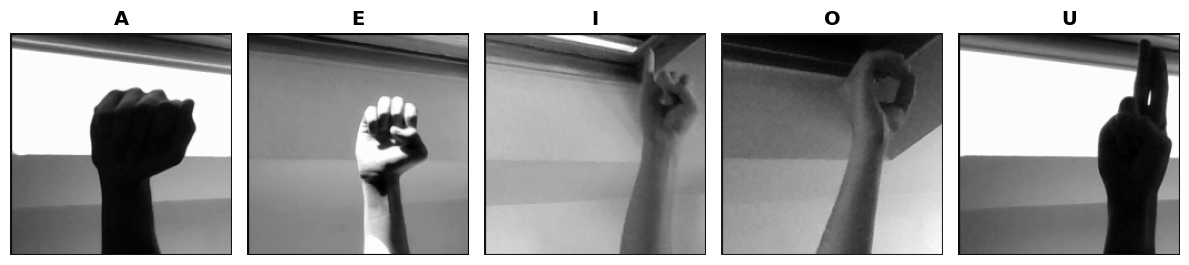

In [8]:
# Função para reverter one-hot encoding para labels inteiros
def reverse_one_hot(y):
    return np.argmax(y, axis=1)

# Reverte o one-hot encoding para y_train
y_train_int = reverse_one_hot(y_train)

# Mapeia os índices das vogais (supondo que classes = ['A', 'E', 'I', 'O', 'U'])
vogais = ['A', 'E', 'I', 'O', 'U']

# Seleciona uma imagem aleatória de cada classe
indices = [np.random.choice(np.where(y_train_int == i)[0]) for i in range(5)]

# Cria a figura
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[indices[i]].reshape(target_dims[:-1]), cmap='gray')
    ax.set_title(vogais[i], fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

filename = "libravogaisneuralnet.weights.h5"
gpus = get_available_gpus()
if gpus:
    print("GPUs disponíveis:", gpus)
else:
    print("Nenhuma GPU disponível.")
model1 = model()

# Se retreinar = 1, o modelo será treinado novamente, 
# caso contrário, o modelo será carregado a partir de um arquivo .h5
retreinar = 0

epochs = 20  # para melhor resultado aumente as épocas
batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(x_test, y_test, batch_size=batch_size)

# Verifica se já existe um modelo treinado e exportado para um arquivo .h5
if os.path.exists(filename) and retreinar == 0:
    model1.load_weights(filename)
    print("Modelo carregado de", filename)
else:
    model1.summary()
    history = model1.fit(train_generator, validation_data=test_generator, epochs=epochs)
    model1.save_weights(filename)


Nenhuma GPU disponível.


c:\Users\jeans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 197, 197, 64)   │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 97, 97, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 43, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 256)    │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    52,429,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,465,413 (207.77 MB)

 Trainable params: 54,465,413 (207.77 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\jeans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1688 ━━━━━━━━━━━━━━━━━━━━ 3:03:30 7s/step - accuracy: 0.2500 - loss: 1.6106

KeyboardInterrupt: 

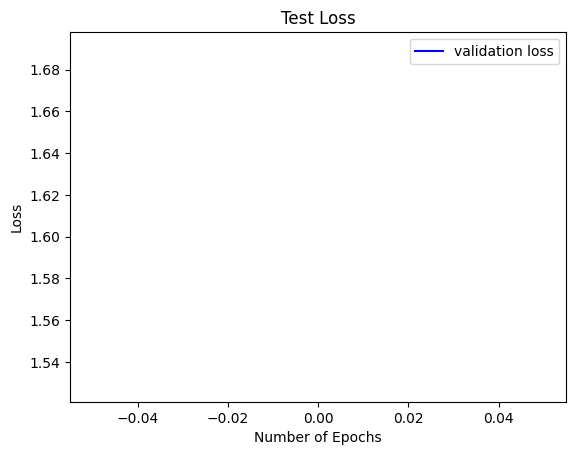

In [8]:
try:
    # Trace as curvas de perda e precisão para treinamento e validação
    plt.plot(history.history['val_loss'], color='b', label="validation loss")
    plt.title("Test Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
except:
    print("Modelo externo carregado. Não é possível plotar o gráfico de perda.")

In [9]:
scores = model1.evaluate(x_test, y_test, verbose=0)
print("\nacc: %.2f%%" % (scores[1]*100))


acc: 20.00%


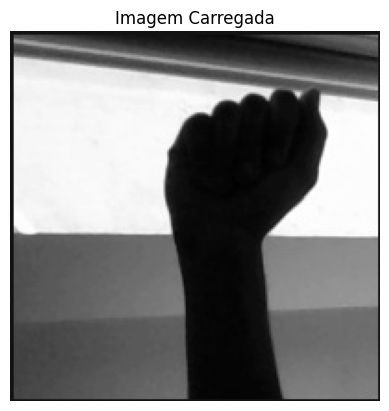

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Classe prevista: I com confiança de 20.12%


In [10]:
# Definiçao das classes
classes = ['A', 'E', 'I', 'O', 'U']

# Carregar a imagem
img_pred = cv2.imread("testes/A_test.jpg", 0)  # Carregar em escala de cinza

# Verificar se a imagem foi carregada corretamente
if img_pred is None:
    raise FileNotFoundError("A imagem não pôde ser carregada. Verifique o caminho do arquivo.")

# Exibir a imagem
plt.imshow(img_pred, cmap='gray')
plt.title("Imagem Carregada")
plt.axis('off')  # Desativar eixos
plt.show()

# Redimensionar a imagem para 28x28
img_pred = cv2.resize(img_pred, target_size)

# Adicionar dimensão do canal (para 1 canal de escala de cinza)
img_pred = np.expand_dims(img_pred, axis=-1)  # Formato (28, 28, 1)

# Adicionar dimensão do lote (1, 28, 28, 1)
img_pred = np.expand_dims(img_pred, axis=0)

# Normalizar a imagem (valores entre 0 e 1)
img_pred = img_pred.astype('float32') / 255.0

# Fazer previsões
predictions = model1.predict(img_pred)  # Obter as previsões
pred = np.argmax(predictions, axis=1)  # Obter a classe prevista
pred_proba = np.max(predictions, axis=1)  # Obter a probabilidade da classe prevista
pred_proba = "%.2f%%" % (pred_proba[0] * 100)  # Formatar a probabilidade como porcentagem

# Exibir resultados
print("Classe prevista:", classes[pred[0]], "com confiança de", pred_proba)